## 本次作業想比較使用原本的整個CNN_layers來進行遷移學習及使用一部分CNN_layers進行的差別

## 1.載入套件及資料集

In [103]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np

# Layers for FNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Layers for CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, Adam

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 2.資料前處理

In [104]:
name_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [105]:
# Load CIFAR 10
(X_train, y_train0), (X_test, y_test0) = datasets.cifar10.load_data()

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

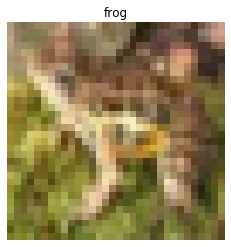

In [106]:
idx = np.random.randint(X_train.shape[0])
X_sample = X_train[idx]
y_sample = y_train0[idx].squeeze()

plt.imshow(X_sample)
plt.title(name_list[y_sample])
plt.axis('off');

## 3.使用第二個使用Sequential建立模型的方式

In [111]:
CNN_layers_1 = [Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', name='Conv_1_1'),
              MaxPool2D(),
              Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv_2_1'),
              MaxPool2D()]
CNN_layers_2 = [Conv2D(512, (3, 3), padding='same', activation='relu', name='Conv_3_2'),
              GlobalAveragePooling2D()]

FC_layers = [Dense(units=256, activation='relu'),
             Dense(units=10, activation='softmax')]

In [112]:
CNN_layers_1 + CNN_layers_2 + FC_layers

In [123]:
model = Sequential(CNN_layers_1+CNN_layers_2+FC_layers)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_2 (Conv2D)            (None, 8, 8, 512)         590336    
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)             

### 編譯模型

In [124]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(),
              metrics=['categorical_accuracy'])

### 訓練模型

In [125]:
model.fit(X_train, y_train, 
          batch_size=128, 
          epochs=3,
          validation_data=(X_test, y_test)
          )

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 11s 227us/sample - loss: 1.1605 - categorical_accuracy: 0.5807 - val_loss: 1.1767 - val_categorical_accuracy: 0.5752
Epoch 2/3
50000/50000 [==============================] - 10s 207us/sample - loss: 1.0770 - categorical_accuracy: 0.6135 - val_loss: 1.1260 - val_categorical_accuracy: 0.5952
Epoch 3/3
50000/50000 [==============================] - 10s 209us/sample - loss: 1.0104 - categorical_accuracy: 0.6395 - val_loss: 1.0205 - val_categorical_accuracy: 0.6437


### 模型預測

In [126]:
score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 2s 162us/sample - loss: 1.0205 - categorical_accuracy: 0.6437
Train Accuracy: 65.17999768257141
Test Accuracy: 64.37000036239624


In [127]:
model.save('CIFAR10_CNN.h5')  

In [128]:
model.layers

## 4.Layer Transfer

In [130]:
# Load CIFAR 100
(U_train, v_train0), (U_test, v_test0) = datasets.cifar100.load_data()

# Normalize the range of featurs
U_train = U_train / U_train.max()
U_test = U_test / U_test.max()

# One-hot encoding
v_train = to_categorical(v_train0, 100)
v_test = to_categorical(v_test0, 100)

In [131]:
FC_layers_CF100 = [Dense(units=256, activation='relu'),
                   Dense(units=128, activation='relu'),
                   Dense(units=100, activation='softmax')]

In [134]:
model_CF100v1 = Sequential(CNN_layers_1+CNN_layers_2+FC_layers_CF100)

In [135]:
model_CF100v1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_2 (Conv2D)            (None, 8, 8, 512)         590336    
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)             

### 將借來的CNN_layers凍結

In [136]:
for layer in CNN_layers_1:
    layer.trainable = False

In [137]:
for layer in CNN_layers_2:
    layer.trainable = False

### 確定借來的部分確實Non-trainable

In [138]:
model_CF100v1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_2 (Conv2D)            (None, 8, 8, 512)         590336    
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)             

In [139]:
model_CF100v1.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])

model_CF100v1.fit(U_train, v_train,
                batch_size=128, 
                epochs=5,
                validation_data=(U_test, v_test)
                )

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 159us/sample - loss: 3.6881 - categorical_accuracy: 0.1377 - val_loss: 3.2845 - val_categorical_accuracy: 0.2001
Epoch 2/5
50000/50000 [==============================] - 5s 109us/sample - loss: 3.1556 - categorical_accuracy: 0.2185 - val_loss: 3.0549 - val_categorical_accuracy: 0.2408
Epoch 3/5
50000/50000 [==============================] - 5s 109us/sample - loss: 2.9847 - categorical_accuracy: 0.2511 - val_loss: 2.9455 - val_categorical_accuracy: 0.2625
Epoch 4/5
50000/50000 [==============================] - 5s 108us/sample - loss: 2.8769 - categorical_accuracy: 0.2751 - val_loss: 2.8484 - val_categorical_accuracy: 0.2844
Epoch 5/5
50000/50000 [==============================] - 5s 110us/sample - loss: 2.7924 - categorical_accuracy: 0.2942 - val_loss: 2.7863 - val_categorical_accuracy: 0.2952


In [140]:
score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 2s 154us/sample - loss: 1.0205 - categorical_accuracy: 0.6437
Train Accuracy: 65.17999768257141
Test Accuracy: 64.37000036239624


### 此結果確實與第一次預測的相同(65/64)

## 5.若只凍結CNN_layer的一部分

In [141]:
model_CF100v2 = Sequential(CNN_layers_1+CNN_layers_2+FC_layers_CF100)

In [142]:
model_CF100v1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_2 (Conv2D)            (None, 8, 8, 512)         590336    
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)             

### 只將CNN_layers_1凍結

In [143]:
for layer in CNN_layers_1:
    layer.trainable = False

In [147]:
for layer in CNN_layers_2:
    layer.trainable = True

In [149]:
model_CF100v2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_2 (Conv2D)            (None, 8, 8, 512)         590336    
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)             

In [150]:
model_CF100v2.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])

model_CF100v2.fit(U_train, v_train,
                batch_size=128, 
                epochs=5,
                validation_data=(U_test, v_test)
                )

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 169us/sample - loss: 2.7231 - categorical_accuracy: 0.3045 - val_loss: 2.6621 - val_categorical_accuracy: 0.3208
Epoch 2/5
50000/50000 [==============================] - 7s 146us/sample - loss: 2.5890 - categorical_accuracy: 0.3332 - val_loss: 2.6018 - val_categorical_accuracy: 0.3389
Epoch 3/5
50000/50000 [==============================] - 7s 147us/sample - loss: 2.4900 - categorical_accuracy: 0.3504 - val_loss: 2.5041 - val_categorical_accuracy: 0.3536
Epoch 4/5
50000/50000 [==============================] - 7s 147us/sample - loss: 2.4163 - categorical_accuracy: 0.3684 - val_loss: 2.4289 - val_categorical_accuracy: 0.3728
Epoch 5/5
50000/50000 [==============================] - 7s 147us/sample - loss: 2.3432 - categorical_accuracy: 0.3828 - val_loss: 2.4122 - val_categorical_accuracy: 0.3746


In [151]:
score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 2s 163us/sample - loss: 1.1115 - categorical_accuracy: 0.6180 - loss: 1.1067 - categori
Train Accuracy: 62.69000172615051
Test Accuracy: 61.799997091293335


### 得知準確度確實會不一樣 且準確度低於將CNN_layers_1和CNN_layers_2都凍結住的model_CF100v1